# [금융 AI](http://www.kmooc.kr/courses/course-v1:CAUk+CAU_AI03+2020_1/about) 기말고사
교수: 유시용 <br>
제출자: 최규형(choigww@gmail.com)<br>
제출일: 21.02.01
## 주의사항
- 주어진 ipynb 파일을 참고하여, 문제를 코딩하여 실행시켜 결과를 출력하여 최종 ipynb 파일을 업로드 해주세요.
- 파일은 구글 Colab에서 실행시켜주세요.
- 본 기말고사는 한국거래소에 있는 주식을 대상으로 모멘텀 투자전략의 수익률을 추정해보고자 한다. 예를 들어서, 모멘텀 계산방식은 다음과 같다:
    - 시점 t에서, (한 달 모멘텀 수익률) = (t − 23) 에서 t 시점까지의 종가(Close) 수익률).
    - 한 달 기간은 거래일 기준으로 23일로 가정.
    - 데이터는 ”FinanceDataReader”를 통해서 다운로드. 
    - (모멘텀 계산기간: 2010.1.4 – 2020.11.30; 데이터 주기 (frequency) : daily)

In [1]:
#!pip install -U finance-datareader;
import pandas as pd
import numpy as np 
import datetime as dt
import pandas_datareader.data as pdr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import FinanceDataReader as fdr
from datetime import datetime, timedelta 
import math
from scipy.stats import skew, kurtosis
import csv 
import os.path 
import time

In [3]:
# 한국거래소에 있는 주식의 데이터를 가져옴
krx = fdr.StockListing('KOSPI')
krx

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,이현우,http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
6,152100,KOSPI,ARIRANG 200,NaN,NaN,NaT,NaN,NaN,NaN,NaN
7,295820,KOSPI,ARIRANG 200동일가중,NaN,NaN,NaT,NaN,NaN,NaN,NaN
8,253150,KOSPI,ARIRANG 200선물레버리지,NaN,NaN,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
6992,215620,KOSPI,흥국 S&P코리아로우볼,NaN,NaN,NaT,NaN,NaN,NaN,NaN
6994,000540,KOSPI,흥국화재,보험업,손해보험,1974-12-05,12월,권중원,http://www.insurance.co.kr,서울특별시
6995,000547,KOSPI,흥국화재2우B,NaN,NaN,NaT,NaN,NaN,NaN,NaN
6996,000545,KOSPI,흥국화재우,NaN,NaN,NaT,NaN,NaN,NaN,NaN


In [4]:
!mkdir krx

In [5]:
from concurrent import futures
import csv

bad = []
krx_list=krx['Symbol'].tolist() #회사 Symbol만을 추출해서 list로 만든다.

In [6]:
# Default Date : 2010.01.04 ~ 2020.11.30
default_start = dt.datetime(2010,1,4)
default_end = dt.datetime(2020,11,30)

def download(krx_item):
    sym=krx_item
    df=fdr.DataReader(sym, default_start, default_end)
    dfnew=df.copy()
    dfnew['Symbol']  =sym
    dfnew.to_csv(f"krx/{sym}.csv", quoting=csv.QUOTE_MINIMAL)    
    
workers = min(30,len(krx))
with futures.ThreadPoolExecutor(workers) as executor: 
    res = executor.map(download, krx_list) 

In [7]:
remove_list=[]

import os.path 

stocks=pd.DataFrame()
for krx_item in krx_list:
    filename=f"krx/{krx_item}.csv"
    status=True
    if os.path.isfile(filename):
        tmp=pd.read_csv(f"krx/{krx_item}.csv",parse_dates=True) 
    if ('Close' in tmp.columns) and ('Date' in tmp.columns):
        tmp.set_index(tmp['Date'],inplace=True,drop=False) 
        tmp_close=tmp['Close'].rename(krx_item) 
        stocks=pd.concat([stocks,tmp_close],axis=1,sort=True) 
        status=False

    if status:
        remove_list.append(krx_item)

for remove_item in remove_list: 
    krx_list.remove(remove_item)

stocks = stocks.loc[:,~stocks.columns.duplicated()];

In [8]:
# 개별 주식들 close
stocks_close = stocks

# 개별 주식들의 return. log(T시점 종가 / T-1시점 종가)
with np.errstate(divide='ignore'):
    stocks_return = 100 * np.log((stocks_close / stocks_close.shift(1)).astype('float'))

# 코스피 close
kospi = pdr.DataReader('^KS11', 'yahoo', default_start, default_end) #KOSPI
kospi.index = pd.to_datetime(kospi.index).strftime("%Y-%m-%d")  # 기본 format이 time까지 잡혀서 reformat
kospi_close = kospi['Close']
kospi_return = 100 * np.log(kospi_close / kospi_close.shift(1))


In [9]:
stocks_return

,095570,006840,152100,295820,253150,253160,278420,292750,309170,309210,...,081660,005870,079980,005010,069260,215620,000540,000547,000545,003280
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,NaN,-1.217330,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.562020,NaN,1.250016,-3.256247,NaN,-3.264385,-1.783992,-1.142870,-0.614846
2010-01-06,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.569447,NaN,3.058342,1.723736,NaN,0.900907,2.176149,0.458716,-0.707342
2010-01-07,NaN,0.916811,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.175716,NaN,0.300752,-1.723736,NaN,-2.881170,-2.176149,-2.549385,7.847162
2010-01-08,NaN,0.600137,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.659198,NaN,-0.300752,0.690769,NaN,-0.927364,0.000000,0.000000,-0.823728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,-0.215285,5.531364,0.553465,-0.267308,1.017211,-1.077763,0.305717,0.000000,1.328293,-1.272552,...,-2.293679,1.669488,0.246609,-0.273973,1.013180,0.829020,1.257878,0.865806,1.355953,0.000000
2020-11-25,-0.865806,-2.038576,-0.582077,-0.536770,-1.288214,1.383573,-1.228517,-0.464469,-2.127402,2.251238,...,1.268029,-0.331675,-0.617667,2.036730,-1.421344,-0.933133,2.643326,1.497354,-5.537747,0.000000
2020-11-26,-0.763779,-0.919547,1.064567,0.322408,1.955724,-2.082605,0.493219,0.865271,1.655035,1.347403,...,-1.500317,-0.166251,0.000000,0.268457,-1.027758,-0.052097,-0.348432,-0.638980,-3.993271,0.000000


In [ ]:
# BUG. 몇몇 날짜는 krx.stock 값은 없고 kospi 값만 있음.

# ks = set(kospi.index.strftime("%Y-%m-%d"))
# # print(ks)
# ss = set(stocks.index)
# # print(ss)
# print(sorted(list(ss - ks)))

In [10]:
stocks_close

,095570,006840,152100,295820,253150,253160,278420,292750,309170,309210,...,081660,005870,079980,005010,069260,215620,000540,000547,000545,003280
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,NaN,10331,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7170,NaN,15900,17885,NaN,6850,5090,2200,1142
2010-01-05,NaN,10206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7430,NaN,16100,17312,NaN,6630,5000,2175,1135
2010-01-06,NaN,10206,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7700,NaN,16600,17613,NaN,6690,5110,2185,1127
2010-01-07,NaN,10300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7610,NaN,16650,17312,NaN,6500,5000,2130,1219
2010-01-08,NaN,10362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7560,NaN,16600,17432,NaN,6440,5000,2130,1209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,4640.0,22300,35149.0,9340.0,33595.0,6460.0,8190.0,16185.0,15915.0,14055.0,...,43100.0,6040,8120.0,7290,24800,9690.0,2800,23200,14850,258
2020-11-25,4600.0,21850,34945.0,9290.0,33165.0,6550.0,8090.0,16110.0,15580.0,14375.0,...,43650.0,6020,8070.0,7440,24450,9600.0,2875,23550,14050,258
2020-11-26,4565.0,21650,35319.0,9320.0,33820.0,6415.0,8130.0,16250.0,15840.0,14570.0,...,43000.0,6010,8070.0,7460,24200,9595.0,2865,23400,13500,258


코스피

In [5]:
# Get data as dataframe(['Close', 'Lagged Close', 'Return']) of KOSPI or random stock.
# Default Date : 2010.01.04 ~ 2020.11.30

def getStockData (ticker, start=None, end=None) :
  # Setting default values for start day and end day
    if start is None :
        start = default_start
    if end is None :
        end = default_end

    start = start.strftime("%Y-%m-%d")
    end = end.strftime("%Y-%m-%d")  

    df = pd.DataFrame(columns=['Close', 'Lagged Close', 'Return'])

    if ticker == 'kospi' :
        df['Close'] = kospi['Close']
        df['Lagged Close'] = kospi['Close'].shift(1)
    else :
        try : 
            df['Close'] = stocks_close[ticker]
            df['Lagged Close'] = stocks_close[ticker].shift(1)
        except ValueError :
            return df
  
    df['Return'] = 100 * np.log( df['Close'] / df['Lagged Close'] )

    return df.loc[start:end]

### data export

In [16]:
# stocks_return.to_csv('./csv/stocks_return.csv', encoding='utf-8-sig')
# stocks_close.to_csv('./csv/stocks_close.csv', encoding='utf-8-sig')
# kospi.to_csv('./csv/kospi.csv', encoding='utf-8-sig') 
# kospi_close.to_csv('./csv/kospi_close.csv', encoding='utf-8-sig')
# kospi_return.to_csv('./csv/kospi_return.csv', encoding='utf-8-sig')

### data import

In [2]:
def import_stock_csv(path):
    df = pd.read_csv(path, index_col=0)
    df.index = pd.to_datetime(df.index)
    return df

In [3]:
stocks_return = import_stock_csv('./csv/stocks_return.csv')
stocks_close = import_stock_csv('./csv/stocks_close.csv')
kospi = import_stock_csv('./csv/kospi.csv')
kospi_close = import_stock_csv('./csv/kospi_close.csv')
kospi_return = import_stock_csv('./csv/kospi_return.csv')

### `getStockData` 함수 use example

In [6]:
getStockData('kospi', dt.datetime(2010, 1, 4), dt.datetime(2020, 11, 30)).head()

,Close,Lagged Close,Return
Date,,,
2010-01-04,1696.140015,NaN,NaN
2010-01-05,1690.619995,1696.140015,-0.325977
2010-01-06,1705.319946,1690.619995,0.865742
2010-01-07,1683.449951,1705.319946,-1.290751
2010-01-08,1695.260010,1683.449951,0.699090


In [11]:
start = dt.datetime(2010,1,4)
end = dt.datetime(2020,11,30)

### 문제 1. (데이터 준비)
KOSPI 지수와 개별 주식별로 일별로 다음 종가(Close)와 수익률(%)의 두 가지 종류의 데이터를 생성하시오.
- 수익률은 다음 공식으로 계산하시오:
    - rt = 100 × ln(Closet/Closet−1). 
- KOSPI 지수와 임의의 한 주식을 선택하여 결과를 출력하시오.



In [394]:
ss

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,16180.0,16000.0,16060.0,16180.0,11950800.0,13192.374023
2010-01-05,16580.0,16300.0,16520.0,16440.0,27925850.0,13404.367188
2010-01-06,16820.0,16520.0,16580.0,16820.0,22948850.0,13714.202148
2010-01-07,16820.0,16260.0,16820.0,16260.0,22107950.0,13257.604492
2010-01-08,16420.0,16120.0,16400.0,16420.0,14777550.0,13388.059570
...,...,...,...,...,...,...
2020-11-24,69500.0,67000.0,67900.0,67700.0,32158235.0,66038.039062
2020-11-25,68300.0,66500.0,67900.0,66600.0,32447065.0,64965.039062
2020-11-26,68000.0,66000.0,66100.0,68000.0,19023323.0,66330.671875


In [17]:
kospi_ss = pd.DataFrame({
    'kospi' : kospi['Close'],
    'ss' : ss['Close']
}).dropna()

kospi_ss.head()

,kospi,ss
Date,,
2010-01-04,1696.140015,16180.0
2010-01-05,1690.619995,16440.0
2010-01-06,1705.319946,16820.0
2010-01-07,1683.449951,16260.0
2010-01-08,1695.260010,16420.0


In [18]:
kospi_ss_ret = kospi_ss.pct_change() * 100
kospi_ss_ret.columns = ['r_'+cname for cname in kospi_ss.columns]
kospi_ss_ret.head()

,r_kospi,r_ss
Date,,
2010-01-04,NaN,NaN
2010-01-05,-0.325446,1.606922
2010-01-06,0.869501,2.311436
2010-01-07,-1.282457,-3.329370
2010-01-08,0.701539,0.984010


### 문제 2. (모멘텀 계산)
개별 주식의 Close를 활용하여,
- 1개월(23일,1m)
- 3개월(65일, 3m),
- 6개월(130일, 6m),
- 9개월(190일, 9m),
- 12개월(253일, 12m)

등의 모멘텀을 계산하시오. KOSPI 지수와 임의의 한 주식을 선택하여 결과를 출력하시오.

$$r_t^{1m}=100 \ \times \ \text{ln}(\text{Close}_{t}/\text{Close}_{t-23})$$
$$r_t^{3m}=100 \ \times \ \text{ln}(\text{Close}_{t}/\text{Close}_{t-65})$$
$$\vdots$$
$$r_t^{12m}=100 \ \times \ \text{ln}(\text{Close}_{t}/\text{Close}_{t-253})$$


In [30]:
# 현재 시점 배제
kospi_ss_lag = kospi_ss.shift(1)

# 모멘텀 수익률 계산
def pct_change_for_lag(df, periodsDay):
    df_pct_change = df.pct_change(periods=periodsDay)*100    
    periodsMon = math.ceil(periodsDay/23)
    
    if periodsMon == 11:
        periodsMon = 12
    
    df_pct_change.columns = [colname + f'_{periodsMon}m' for colname in df_pct_change.columns]
    return df_pct_change

from functools import reduce

# 모멘텀 period
periods = [23, 65, 130, 190, 253]
kospi_ss_lag_m_list = [pct_change_for_lag(kospi_ss_lag, pDay) for pDay in periods]
kospi_ss_lag_m = reduce(lambda left,right: pd.concat([left,right], axis=1), kospi_ss_lag_m_list).dropna()

kospi_ss_lag_m.head()

,kospi_1m,ss_1m,kospi_3m,ss_3m,kospi_6m,ss_6m,kospi_9m,ss_9m,kospi_12m,ss_12m
Date,,,,,,,,,,
2011-01-06,6.783200,9.662398,10.836435,21.862872,23.502589,22.976501,20.728240,8.275862,22.781730,16.440049
2011-01-07,6.148907,4.026846,9.121046,17.276166,24.272360,21.251630,20.365111,7.019563,22.890426,13.138686
2011-01-10,6.785280,3.483146,9.750900,19.610390,24.521745,20.078227,20.827058,7.217695,22.334812,9.512485
2011-01-11,6.027456,1.775805,9.685469,20.976253,23.494613,18.322581,20.015805,6.257242,23.603916,12.792128
2011-01-12,6.780117,2.815315,10.498385,21.248340,24.627460,18.725618,21.099242,6.658879,23.185827,11.205847


### 문제 3. (포트폴리오 구성)
각 모멘텀 기준(1m, 3m, 6m, 9m, 12m), 일별로, 최상위 주식 20개를 제외한 이후 최상위 10개 주식(best portfolio)(즉, 상위 21∼30위의 10개 주식), 중간순위 10개 주식(median portfolio), 최하위 50개 주식을 제외한 이후의 최하위 10개 주식(worst portfolio)(즉, 하위 51∼60위의 10개 주식)으로 포트폴리오를 구성하시오.

- (a) 각 모멘텀 기준(1m, 3m, 6m, 9m, 12m)으로 구성된 각 포트폴리오 의 구성 개별 주식의 모멘텀을 일별(daily)로 출력하시오.
- (b-1) 각 모멘텀 기준(1m, 3m, 6m, 9m, 12m)으로 구성된 각 포트폴리오의 구성 개별 주식 이름(ticker)을 일별(daily)로 출력하시오.
- (b-2) 그리고 새롭게 편입된 종목이름과 퇴출된 종목이름을 일별(daily)로 출력하시오.
- (c) 각 모멘텀 기준(1m, 3m, 6m, 9m, 12m)으로 구성된 각 포트폴리오의 구성 개별 주식을 1일 보유수익률을 출력하시오.
    - (t 시점에서 구성되었다면, t시점과 t + 1시점 간의 수익률을 의미함)
- (d-1) 각 모멘텀 기준(1m, 3m, 6m, 9m, 12m)으로 구성된 각 포트폴리오의 포트폴리오 일별(daily) 수익률을 계산하시오.
- (d-2) 각 포트폴리오의 일별(daily) 수익률을 다음과 같이 계산하시오.
$$r_{p, t}=\frac{1}{10}\sum_{i \in p}r_{i, t}$$
    - 여기서, p = portfolio (best, median, worst). 주의할 것은, i ∈ p는 t−1시점에서 모멘텀에 의해서 결정되었음. 각 시점에서는 취하는 행동은 2가지임.
        - 1) 직전의 시점에서 구성된 각 포트폴리오(10개 주식)의 수익률을 위 식과 같이 계산한다.
        - 2) 그 시점의 모멘텀을 계산하고, 그 추정된 모멘텀을 기반으로 포트폴리오를 새롭게 구성한다.
        - (매일 포트폴리오를 rebalance하게 됨. Rebalance 기준은 각 모멘텀. 포트폴리오 수익률은 포트폴리오 내의 10개 주식의 일별 수익률의 평균임. 각 모멘텀 기준 (5개)으로 3종류(best, median, worst)의 포트폴리오가 구성되기 때문에, 매일 총 15개의 포트폴리오가 구성됨.)
- (e) 15개의 포트폴리오 수익률 데이터를 출력하시오.

In [33]:
# 총 종목 수 5243개
len(stocks_close.columns)

5243

In [38]:
# 1m, 3m, 6m, 9m, 12m에 대한 개별종목 모멘텀 컬럼 추가
original_columns = stocks_close.columns.tolist
stocks_close_lag = stocks_close.shift(1)

In [40]:
periods = [23, 65, 130, 190, 253]
stocks_close_lag_m_list = [pct_change_for_lag(stocks_close_lag, pDay) for pDay in periods]

In [121]:
# 최소 120개 이상의 non-NA values를 만족하는 row만 남긴다
# NaN 값은 임의의 매우 작은 수로 채운다
stocks_close_lag_m_1 = stocks_close_lag_m_list[0].dropna(thresh=120)
stocks_close_lag_m_3 = stocks_close_lag_m_list[1].dropna(thresh=120)
stocks_close_lag_m_6 = stocks_close_lag_m_list[2].dropna(thresh=120)
stocks_close_lag_m_9 = stocks_close_lag_m_list[3].dropna(thresh=120)
stocks_close_lag_m_12 = stocks_close_lag_m_list[4].dropna(thresh=120)

#### (3-a) 각 모멘텀 기준(1m, 3m, 6m, 9m, 12m)으로 구성된 각 포트폴리오 의 구성 개별 주식의 모멘텀을 일별(daily)로 출력하시오.

In [122]:
# daily momentum, 1m
stocks_close_lag_m_1

,095570_1m,006840_1m,152100_1m,295820_1m,253150_1m,253160_1m,278420_1m,292750_1m,309170_1m,309210_1m,...,081660_1m,005870_1m,079980_1m,005010_1m,069260_1m,215620_1m,000540_1m,000547_1m,000545_1m,003280_1m
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,NaN,-3.029716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-12.133891,NaN,-0.943396,-8.940453,NaN,-11.824818,-2.848723,-5.681818,14.010508
2010-02-08,NaN,-1.842054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-17.227456,NaN,-5.900621,-7.318623,NaN,-9.653092,-2.000000,-5.287356,7.400881
2010-02-09,NaN,-2.459338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-22.077922,NaN,-5.421687,-13.353773,NaN,-11.061286,-6.066536,-8.466819,5.856256
2010-02-10,NaN,-5.776699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-22.470434,NaN,-4.204204,-9.582948,NaN,-9.230769,-4.000000,-6.807512,-2.132896
2010-02-11,NaN,-7.247636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-20.899471,NaN,-6.325301,-10.899495,NaN,-8.074534,-0.400000,-5.633803,-2.646816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,23.178808,19.209040,10.222937,8.579710,21.191691,-18.881988,4.345048,10.214505,12.138522,10.864486,...,11.223203,3.846154,-2.877698,4.428571,5.364807,4.117010,-2.811951,-8.910891,-28.710462,0.000000
2020-11-25,23.568575,24.233983,11.587669,8.164447,24.356839,-20.736196,4.664537,10.591049,14.992775,11.902866,...,7.615481,5.594406,-0.733496,4.291845,7.826087,4.643629,-2.946274,-7.014028,-19.073569,0.000000
2020-11-26,25.683060,19.726027,10.505012,7.212926,21.818182,-19.035847,3.123008,9.778535,12.980421,13.861386,...,4.176611,5.061082,-0.738007,4.201681,4.935622,3.448276,-3.198653,-6.732673,-22.589532,0.000000


In [123]:
# daily momentum, 3m
stocks_close_lag_m_3

,095570_3m,006840_3m,152100_3m,295820_3m,253150_3m,253160_3m,278420_3m,292750_3m,309170_3m,309210_3m,...,081660_3m,005870_3m,079980_3m,005010_3m,069260_3m,215620_3m,000540_3m,000547_3m,000545_3m,003280_3m
Date,,,,,,,,,,,,,,,,,,,,,
2010-04-08,NaN,9.698964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-16.875872,NaN,3.459119,-6.346100,NaN,-6.569343,-3.732809,-5.000000,29.422067
2010-04-09,NaN,12.571037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-19.246299,NaN,3.416149,-3.246303,NaN,-4.977376,-2.000000,-8.045977,29.339207
2010-04-12,NaN,12.571037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-18.831169,NaN,-1.204819,-5.609493,NaN,-6.875934,-4.109589,-8.466819,33.185448
2010-04-13,NaN,9.417476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-19.185283,NaN,-3.303303,-5.597274,NaN,-3.692308,-4.800000,-6.807512,24.692371
2010-04-14,NaN,8.762787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-13.492063,NaN,-4.216867,-6.424966,NaN,-2.173913,-4.800000,-6.103286,28.370554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,48.800000,23.391813,11.502759,11.820896,23.098279,-22.215605,7.363577,10.932145,16.032508,3.715847,...,37.169518,-5.714286,16.883117,9.924812,52.012384,5.895317,17.659574,1.545254,159.292035,0.000000
2020-11-25,47.770701,30.409357,11.818413,9.753231,23.420279,-22.588376,5.745642,10.477816,17.151270,0.500536,...,36.608558,-6.790123,13.566434,7.205882,53.560372,5.670665,20.689655,-0.854701,158.260870,0.000000
2020-11-26,55.405405,30.059524,15.474853,13.987730,32.157800,-27.181768,8.882907,14.376997,20.868891,3.454480,...,44.059406,2.207131,17.982456,10.385757,57.234727,7.322527,31.278539,10.046729,157.798165,0.000000


In [124]:
# daily momentum, 6m
stocks_close_lag_m_6

,095570_6m,006840_6m,152100_6m,295820_6m,253150_6m,253160_6m,278420_6m,292750_6m,309170_6m,309210_6m,...,081660_6m,005870_6m,079980_6m,005010_6m,069260_6m,215620_6m,000540_6m,000547_6m,000545_6m,003280_6m
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-13,NaN,57.874359,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-33.612273,NaN,-1.257862,-10.897400,NaN,-7.153285,-1.375246,-14.090909,52.101576
2010-07-14,NaN,56.741133,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-36.002692,NaN,-3.416149,-8.491220,NaN,-5.731523,4.000000,-13.333333,66.167401
2010-07-15,NaN,55.212620,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-38.831169,NaN,-4.216867,-6.500880,NaN,-6.576981,1.761252,-13.501144,64.330080
2010-07-16,NaN,54.708738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-39.027595,NaN,-4.204204,-2.339418,NaN,-6.000000,4.000000,-12.206573,58.736669
2010-07-19,NaN,53.175063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-38.293651,NaN,-5.421687,-4.273749,NaN,-4.658385,4.000000,-13.380282,57.981803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,22.853369,-9.051724,36.740602,31.715893,82.069532,-51.049475,18.936635,35.894207,33.659574,37.138728,...,41.573034,6.834532,42.857143,12.461538,47.005988,18.131530,14.256198,2.908277,210.052910,0.000000
2020-11-25,21.784777,-10.800000,34.074611,28.827586,74.700988,-48.932806,17.000000,32.772765,33.627204,35.994194,...,26.951399,7.282416,45.259392,9.954751,46.312684,17.739976,16.666667,8.411215,210.669456,0.000000
2020-11-26,19.170984,-11.895161,32.941490,28.049621,71.883908,-48.015873,15.654039,32.320329,28.547855,37.625658,...,19.589041,4.332756,44.883303,9.896603,42.565598,16.504854,10.576923,7.534247,179.880478,0.000000


In [125]:
# daily momentum, 9m
stocks_close_lag_m_9

,095570_9m,006840_9m,152100_9m,295820_9m,253150_9m,253160_9m,278420_9m,292750_9m,309170_9m,309210_9m,...,081660_9m,005870_9m,079980_9m,005010_9m,069260_9m,215620_9m,000540_9m,000547_9m,000545_9m,003280_9m
Date,,,,,,,,,,,,,,,,,,,,,
2010-10-08,NaN,64.243539,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-24.267782,NaN,18.238994,21.330724,NaN,-13.722628,32.220039,57.500000,102.364273
2010-10-11,NaN,68.097198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-26.917900,NaN,16.770186,24.191312,NaN,-11.161388,24.000000,82.988506,103.612335
2010-10-12,NaN,83.127572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-29.870130,NaN,11.445783,21.217283,NaN,-12.556054,15.264188,54.919908,97.604259
2010-10-13,NaN,87.844660,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-29.040736,NaN,10.210210,20.725508,NaN,-9.384615,17.200000,82.629108,84.659557
2010-10-14,NaN,93.360355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-28.835979,NaN,10.843373,20.754933,NaN,-9.316770,21.800000,71.361502,93.879239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,-6.344411,-29.313233,17.757041,19.543018,26.013642,-44.661017,5.097181,18.780273,14.002613,59.943820,...,2.917153,-8.755760,37.055838,-18.506132,27.202073,4.094454,-3.490401,3.603604,113.868613,-34.351145
2020-11-25,-5.402650,-24.662162,18.135986,20.066847,27.350265,-45.416139,5.964549,18.989854,15.026019,59.173273,...,2.253855,-5.625000,32.032520,-17.533937,26.530612,5.348989,-1.060071,16.000000,151.269036,-34.848485
2020-11-26,-5.252317,-24.914089,18.093339,20.743436,26.463298,-44.957983,5.407166,18.700265,12.931284,64.850917,...,3.191489,-5.494505,25.897036,-14.087760,26.030928,5.831772,2.313167,15.158924,137.331081,-33.676093


In [126]:
# daily momentum, 12m
stocks_close_lag_m_12

,095570_12m,006840_12m,152100_12m,295820_12m,253150_12m,253160_12m,278420_12m,292750_12m,309170_12m,309210_12m,...,081660_12m,005870_12m,079980_12m,005010_12m,069260_12m,215620_12m,000540_12m,000547_12m,000545_12m,003280_12m
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-06,NaN,114.238699,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-20.083682,NaN,10.691824,9.589041,NaN,-14.014599,17.681729,27.727273,66.637478
2011-01-07,NaN,119.625710,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-24.495289,NaN,8.695652,14.082717,NaN,-12.669683,18.000000,26.896552,69.691630
2011-01-10,NaN,129.139722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-28.051948,NaN,6.024096,12.700846,NaN,-13.303438,15.851272,23.112128,72.582076
2011-01-11,NaN,127.660194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-28.646518,NaN,5.405405,13.793900,NaN,-9.692308,19.400000,26.760563,61.443806
2011-01-12,NaN,122.669369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-26.984127,NaN,6.927711,13.297384,NaN,-10.248447,19.400000,23.239437,71.133168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-24,10.189573,-37.295691,25.327166,15.503207,40.702348,-52.196193,3.393694,26.228358,37.956781,65.909091,...,-26.254181,-15.263909,27.358491,-30.047847,8.149780,2.462949,-12.776025,16.751269,205.845511,-49.902913
2020-11-25,9.952607,-34.985423,24.284856,13.722148,38.251029,-51.337100,2.631579,24.413867,37.233767,62.204270,...,-26.949153,-14.809591,26.283048,-29.223301,9.492274,2.517986,-12.500000,14.285714,215.286624,-61.434978
2020-11-26,8.747045,-35.066865,23.668472,13.875950,36.622039,-50.714823,1.684263,24.257617,34.056100,66.281087,...,-25.128645,-14.366999,26.291080,-28.115942,9.151786,1.565806,-9.591195,18.939394,197.040169,-70.310702


#### (3-b-1) 각 모멘텀 기준(1m, 3m, 6m, 9m, 12m)으로 구성된 각 포트폴리오의 구성 개별 주식 이름(ticker)을 일별(daily)로 출력하시오.
#### (3-b-2) 그리고 새롭게 편입된 종목이름과 퇴출된 종목이름을 일별(daily)로 출력하시오.

In [218]:
def select_daily_15_portfolio(df):
    
    best_tickles, median_tickles, worst_tickles = [], [], []
    
    best_new_tickles, best_kicked_tickles = [], []
    median_new_tickles, median_kicked_tickles = [], []
    worst_new_tickles, worst_kicked_tickles = [], []
    
    # 데이터프레임의 각 행을 인덱스 포함 순회한다
    for i, row in enumerate(df.iterrows()):
        
        sorted_row = df.iloc[i, :].sort_values(ascending=False).dropna()
        best = [ticker.split('_')[0] for ticker in sorted_row[21:31].index.tolist()]
        median = [ticker.split('_')[0] for ticker in sorted_row[(len(sorted_row)//2-5):(len(sorted_row)//2+5)].index.tolist()]
        worst = [ticker.split('_')[0] for ticker in sorted_row[-61:-51].index.tolist()]
        
        # 첫번째 행이면 empty string 저장하고 pass
        if i == 0:
            
            best_tickles.append(','.join(best))
            median_tickles.append(','.join(median))
            worst_tickles.append(','.join(worst))
            
            best_new_tickles.append('')
            best_kicked_tickles.append('')
            median_new_tickles.append('')
            median_kicked_tickles.append('')
            worst_new_tickles.append('')
            worst_kicked_tickles.append('')
            
        else:
            # 두번째 행 이상이면
            best_tickles.append(','.join(best))
            median_tickles.append(','.join(median))
            worst_tickles.append(','.join(worst))
            
            prev_best = best_tickles[i-1].split(',')
            prev_median = median_tickles[i-1].split(',')
            prev_worst = worst_tickles[i-1].split(',')
            
            best_new_tickles.append(','.join([tname for tname in best if tname not in prev_best]))
            best_kicked_tickles.append(','.join([tname for tname in best_tickles[i-1].split(',') if tname not in best]))
            median_new_tickles.append(','.join([tname for tname in median if tname not in prev_median]))
            median_kicked_tickles.append(','.join([tname for tname in prev_median if tname not in median]))
            worst_new_tickles.append(','.join([tname for tname in worst if tname not in prev_worst]))
            worst_kicked_tickles.append(','.join([tname for tname in prev_worst if tname not in worst]))

    return [best_tickles, median_tickles, worst_tickles,
                best_new_tickles, best_kicked_tickles,
                median_new_tickles, median_kicked_tickles,
                worst_new_tickles, worst_kicked_tickles]

In [178]:
#test
best, median, worst, bn, bk, mn, mk, wn, wk = select_daily_15_portfolio(stocks_close_lag_m_1)

In [220]:
momentum_dfs = [stocks_close_lag_m_1, stocks_close_lag_m_3, stocks_close_lag_m_6, stocks_close_lag_m_9, stocks_close_lag_m_12]
for mdf in momentum_dfs:
    best, median, worst, bn, bk, mn, mk, wn, wk = select_daily_15_portfolio(mdf)
    mdf['best_pf'] = best
    mdf['median_pf'] = median
    mdf['worst_pf'] = worst
    mdf['best_new'] = bn
    mdf['best_kicked'] = bk
    mdf['median_new'] = mn
    mdf['median_kicked'] = mk
    mdf['worst_new'] = wn
    mdf['worst_kicked'] = wk


/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/anaconda3/envs/AI_dev/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [221]:
prob_3_b_columns = ['best_pf', 'median_pf', 'worst_pf', 'best_new', 'best_kicked',
                   'median_new', 'median_kicked', 'worst_new', 'worst_kicked']

In [224]:
stocks_close_lag_m_1[prob_3_b_columns]

,best_pf,median_pf,worst_pf,best_new,best_kicked,median_new,median_kicked,worst_new,worst_kicked
Date,,,,,,,,,
2010-02-05,"011700,071950,004870,010620,095720,013570,0112...","52G068,52G067,52G066,52G065,52G064,52G062,52G0...","093050,006060,000640,047040,009200,090430,0210...",,,,,,
2010-02-08,"095720,001390,000700,011280,009240,013570,0157...","55FD58,55FD57,55FD56,55FD55,55FD54,55FD53,55FD...","042700,096770,003570,000140,007575,003850,0101...","001390,000700,011280,009240,002020,030200","071950,004870,010620,011230,006345,034730","55FD58,55FD57,55FD56,55FD55,55FD54,55FD53,55FD...","52G068,52G067,52G066,52G065,52G064,52G062,52G0...","042700,096770,003570,000140,007575,003850,0101...","093050,006060,000640,047040,009200,090430,0210..."
2010-02-09,"095720,010600,009540,010690,030200,009240,0106...","52G069,52G068,52G067,52G066,52G065,52G064,52G0...","003070,066575,009200,005420,000720,014990,0910...","010600,009540,010690,010620,002720,002390","001390,000700,011280,013570,002020,011700","52G069,52G068,52G067,52G066,52G065,52G064,52G0...","55FD58,55FD57,55FD56,55FD55,55FD54,55FD53,55FD...","003070,066575,009200,005420,000720,014990,0910...","042700,003570,000140,007575,003850,010130,0148..."
2010-02-10,"001780,095720,009240,011280,011000,011690,0078...","52FC76,52FF58,52FF56,52FF60,52G027,52G037,52G0...","097230,000910,001630,001680,006650,007575,0155...","001780,011280,011000,011690,007860,114260,0013...","010600,009540,010690,030200,010620,002720,0157...","52FC76,52FF58,52FF56,52FF60,52G027,52G037,52G0...","52G069,52G068,52G067,52G066,52G065,52G064,52G0...","097230,000910,001630,001680,006650,007575,0155...","003070,066575,009200,005420,000720,014990,0967..."
2010-02-11,"024720,009580,002720,011000,001390,011280,0063...","52FC63,52FC64,52FC65,52FC69,52FC71,52FC72,52FC...","005420,002780,101140,071050,006090,005940,0075...","009580,002720,006345,092200","001780,095720,009240,114260","52FC63,52FC64,52FC65,52FC69,52FC71,52FC72,52FC...","52FC76,52FF58,52FF56,52FF60,52G027,52G037,52G0...","005420,002780,101140,071050,006090,005940,002790","000910,001680,006650,015590,091090,001570,000020"
...,...,...,...,...,...,...,...,...,...
2020-11-24,"091810,033180,005030,093230,285130,500032,5700...","57FH51,57FH50,57G410,57FH49,57FH48,57G411,57G4...","500024,005090,000225,570032,550043,105630,0336...","093230,285130,570046,023960,007460,004270","001440,530069,500054,101140,007860,005950","57FH51,57FH50,57G410,57FH49,57FH48,57G411,57G4...","58FF63,58FF62,58FF61,58FF60,58FF59,58FF58,58FF...","500024,005090,570032,105630,033660,500002,001770","009415,000080,002787,074610,014285,003720,010145"
2020-11-25,"006370,012280,091810,005030,570046,500032,0148...","57FN59,57FN60,57FN61,57FN62,57FN63,57FN64,57FN...","306520,252410,017900,123310,520005,192080,5500...","006370,012280,014820,249420","033180,285130,023960,007460","57FN59,57FN60,57FN61,57FN62,57FN63,57FN64,57FN...","57FH51,57FH50,57G410,57FH49,57FH48,57G411,57G4...","306520,252410,017900,123310,520005,192080,5500...","500024,005090,000225,570032,550043,105630,0336..."
2020-11-26,"005030,012280,092220,010145,082740,267850,0014...","57FH72,57G398,57FH71,57G405,57G406,57G407,57FH...","271050,225130,550033,002785,570023,009415,5000...","092220,010145,082740,267850,001440,068270,003850","006370,091810,570046,500032,014820,249420,093230","57FH72,57G398,57FH71,57G405,57G406,57G407,57FH...","57FN59,57FN60,57FN61,57FN62,57FN63,57FN64,57FN...","271050,225130,002785,570023,009415,500003,5000...","306520,252410,017900,123310,520005,114800,0010..."


In [222]:
stocks_close_lag_m_3[prob_3_b_columns]

,best_pf,median_pf,worst_pf,best_new,best_kicked,median_new,median_kicked,worst_new,worst_kicked
Date,,,,,,,,,
2010-04-08,"000950,025750,027740,006340,004060,011280,0024...","009810,023800,117700,006220,005740,005490,0009...","000880,005870,007570,016450,005110,001270,0336...",,,,,,
2010-04-09,"004100,009460,000950,000700,006340,002220,0201...","001500,005420,029780,015590,000500,023530,0239...","008250,072130,030210,005110,111770,001270,0164...","004100,009460,000700,002220,020120","027740,004060,011280,002420,011700","001500,005420,029780,015590,000500,023530,0239...","009810,023800,117700,006220,005740,005490,0009...","008250,072130,030210,003850,047040,004720","000880,005870,007570,033660,000640,003410"
2010-04-12,"007810,027740,000950,000700,004100,011690,0135...","000105,108670,001250,003010,100220,096760,0042...","001230,030210,008260,006125,003850,069730,0051...","007810,027740,011690,005070","006340,002220,020120,025750","000105,108670,001250,003010,100220,096760,0023...","001500,005420,029780,015590,000500,023530,0239...","001230,008260,006125,069730,002790,034120","008250,111770,001270,016450,047040,004720"
2010-04-13,"004100,012800,006340,000950,005070,027740,0026...","010420,000300,025890,000240,023530,006220,0015...","078520,033660,008260,002350,003850,023960,0048...","012800,006340,002600,015230,009580","007810,000700,011690,009460,010620","010420,000300,025890,000240,023530,006220,0015...","000105,108670,001250,003010,096760,004255,0023...","078520,033660,002350,023960,004840,063160,000020","001230,030210,006125,069730,005110,034120,072130"
2010-04-14,"011690,012800,001380,007120,020560,027740,0009...","006060,003300,006220,004255,117700,012200,0023...","001270,001520,002350,034120,001200,092220,0000...","011690,001380,007120,020560,107590,002220","004100,006340,002600,013570,015230,009580","006060,003300,004255,117700,012200,002360,0155...","010420,000300,025890,000240,023530,001510,1002...","001270,001520,034120,001200,092220,003475,0200...","078520,033660,008260,003850,023960,004840,0631..."
...,...,...,...,...,...,...,...,...,...
2020-11-24,"005950,075580,001755,071970,004830,001440,0137...","58FG09,58FG08,58FG07,58FG06,58FG05,58FG20,58FG...","092200,500002,530031,033250,000725,004720,5200...","005950,071970,009070,000995","017550,083420,034020,005880","58FG09,58FG08,58FG07,58FG06,58FG05,58FG20,58FG...","57FF57,57FF56,57FF55,57FF54,57FF53,57FF52,57G3...","092200,500002,530031,000725,004720,520005,0059...","550045,500021,015540,145995,008350,000885,0048..."
2020-11-25,"001755,014710,005950,004835,001440,013700,0034...","58FF60,58FF61,58FF62,58FF63,58FF64,58FF65,58FF...","530036,520005,134790,021240,004840,007570,1459...","014710,004835,003495,011280","075580,071970,009070,000995","58FF60,58FF61,58FF62,58FF63,58FF64,58FF65,58FF...","58FG09,58FG08,58FG07,58FG06,58FG05,58FG20,58FG...","530036,134790,021240,004840,145990,192080,510010","092200,500002,530031,033250,000725,004720,005965"
2020-11-26,"005880,004270,000995,014710,013700,001440,0059...","58FF18,58FE92,58FE91,58FE90,58FE89,58FE88,58FE...","000140,520007,001140,074610,500002,510010,5500...","005880,004270,000995,006380,298020,093230","001755,004835,003495,002785,011280,004830","58FF18,58FE92,58FE91,58FE90,58FE89,58FE88,58FE...","58FF60,58FF61,58FF62,58FF63,58FF64,58FF65,58FF...","000140,520007,001140,074610,500002,550043,5000...","530036,520005,134790,021240,004840,007570,5000..."


In [225]:
stocks_close_lag_m_6[prob_3_b_columns]

,best_pf,median_pf,worst_pf,best_new,best_kicked,median_new,median_kicked,worst_new,worst_kicked
Date,,,,,,,,,
2010-07-13,"003670,033530,052690,005850,004710,013520,0247...","029780,023590,069730,026890,005500,001230,0008...","091090,001200,001470,027970,111770,007630,0075...",,,,,,
2010-07-14,"033530,006340,003670,020760,013520,005850,0037...","000860,000500,009200,001525,000545,017180,0942...","003470,001200,089470,004720,003475,091090,1117...","006340,020760,003720,003495,007860","052690,024720,011070,034730,012510","000500,009200,001525,017180,094280,109070,001250","029780,023590,069730,026890,005500,001230,063160","003470,004720,003475,012630","001470,007630,007575,006360"
2010-07-15,"006340,005850,033530,003670,052690,003720,0848...","000885,002410,092230,034020,037270,000500,0012...","007460,111770,012630,034120,031820,001520,0063...","052690,084870,012510","020760,004710,007860","000885,002410,092230,034020,037270,001230,014825","001525,000545,017180,094280,109070,001250,000970","007460,034120,031820,001520,006360,008930,002630","003470,001200,089470,003475,091090,027970,072130"
2010-07-16,"102280,006340,052690,033530,004710,003720,0034...","036530,034020,001630,004690,000545,069620,1090...","003620,002380,007630,111770,072130,006360,0026...","102280,004710","005850,084870","036530,001630,004690,000545,069620,109070,0034...","000885,002410,092230,037270,000500,001230,0008...","003620,002380,007630,072130,000020,002760,032350","007460,012630,034120,031820,001520,004720,008930"
2010-07-19,"033530,102280,005850,012510,006340,003495,0135...","053690,025890,036460,029780,017390,069620,0044...","012600,003620,002380,015540,072130,093230,0075...","005850,009155","052690,004710","053690,025890,036460,029780,017390,004430,0043...","036530,034020,001630,004690,000545,003470,0015...","012600,015540,093230,007575,007570,008930","007630,111770,006360,000020,002760,032350"
...,...,...,...,...,...,...,...,...,...
2020-11-24,"019175,000545,037270,023800,003620,033270,0050...","57G426,57G439,57G449,57G448,57G447,57G446,57G4...","33637L,111110,530002,001520,500005,510006,1265...",001755,243890,"57G426,57G439,57G449,57G448,57G447,57G446,57G4...","57G346,57G347,57G348,57G423,57G422,57G421,57G4...","33637L,530002,001520,500005,003060","308170,012690,145670,306520,500054"
2020-11-25,"009830,037270,000545,003495,007860,023800,0307...","57G208,57G207,57G206,57G205,57G363,57G204,57G2...","251340,008350,530002,570032,111110,007460,5000...","009830,003495,007860,030790","019175,003620,004830,001755","57G208,57G207,57G206,57G205,57G363,57G204,57G2...","57G426,57G439,57G449,57G448,57G447,57G446,57G4...","251340,008350,007460,016380,145670","33637L,001520,126560,003060,123310"
2020-11-26,"019175,075580,009830,001755,037270,023800,0307...","57G448,57G447,57G446,57G445,57G444,57G443,57G4...","002070,510006,570032,253240,123310,306520,1456...","019175,075580,001755,000995","003495,007860,033270,011000","57G448,57G447,57G446,57G445,57G444,57G443,57G4...","57G208,57G207,57G206,57G205,57G363,57G204,57G2...","002070,253240,123310,306520,114800,500054,252410","251340,008350,530002,111110,007460,500005,016380"


In [226]:
stocks_close_lag_m_9[prob_3_b_columns]

,best_pf,median_pf,worst_pf,best_new,best_kicked,median_new,median_kicked,worst_new,worst_kicked
Date,,,,,,,,,
2010-10-08,"014915,004920,024720,001140,000760,034730,0072...","001510,001020,001790,004140,032640,002820,0318...","003410,002995,007575,005870,101060,033660,0001...",,,,,,
2010-10-11,"004920,004380,024720,000760,001140,052690,0335...","084690,004140,001510,009460,078000,009240,0053...","066570,000180,093240,033660,007575,010050,0126...","004380,033530,073240,001780","014915,007210,000590,020760","084690,009460,078000,009240,005305,005300,0053...","001020,001790,032640,002820,031820,036530,0015...","066570,093240,010050,009270,014440","003410,002995,005870,101060,003070"
2010-10-12,"020560,014915,024720,001140,004920,033530,0732...","001510,002320,002870,014790,114800,034220,0015...","032350,016450,033660,011090,010050,000180,0026...","020560,014915,007210,102280","004380,000760,052690,034730","002320,002870,014790,114800,034220,001500,0082...","084690,004140,009460,078000,009240,005305,0053...","032350,016450,002630,023960,000020,084010","066570,093240,007575,012600,009270,014440"
2010-10-13,"084870,003350,020560,001140,024720,033530,0017...","092230,001720,105560,002170,002320,025890,0053...","033660,000180,016450,011090,091090,002630,0100...","084870,003350,049800,000270,023810","014915,004920,073240,007210,102280","092230,001720,105560,025890,005300,000540,109070","001510,002870,014790,034220,001500,008260,003470","091090,014440","032350,023960"
2010-10-14,"004835,004920,084870,013570,000325,001140,0335...","074610,017180,015760,003470,009460,001720,0105...","003475,002700,002990,033660,005500,032350,0001...","004835,004920,013570,000325,007210,010780,073240","003350,020560,024720,001780,049800,000270,023810","074610,017180,015760,003470,009460,010580,0142...","092230,105560,002170,002320,025890,005300,0005...","003475,002700,002990,005500,032350","016450,091090,002630,014440,084010"
...,...,...,...,...,...,...,...,...,...
2020-11-24,"033270,016710,007570,034020,271980,006120,0068...","57G092,57G091,57G090,57G089,57G088,57G409,57G0...","004060,251340,301410,500028,025620,530056,5300...",271980,000545,"57G092,57G091,57G090,57G089,57G088,57G409,57G0...","57G166,57G165,57G164,57G163,57G162,57G161,57G1...","251340,301410,219390","078520,006840,570042"
2020-11-25,"033270,016710,034020,007570,006120,271980,0000...","57G231,57G230,57G254,57G255,57G256,57G257,57G2...","291620,250780,025620,251340,004060,301410,5000...","000020,030790,298040","004830,075580,550012","57G231,57G230,57G254,57G255,57G256,57G257,57G2...","57G092,57G091,57G090,57G089,57G088,57G409,57G0...","291620,250780,500021,218420,011300,500038","500028,530056,530033,003280,090435,219390"
2020-11-26,"034020,016710,030790,033270,007570,006120,2980...","57G256,57G278,57G277,57G276,57G275,57G274,57G2...","011300,500021,218420,275750,500038,291620,2507...","001515,092220","271980,006890","57G276,57G275,57G274,57G273,57G272,57G271,57G270","57G231,57G230,57G254,57G255,57G257,57G280,57G279","275750,500007","025620,004060"


In [227]:
stocks_close_lag_m_12[prob_3_b_columns]

,best_pf,median_pf,worst_pf,best_new,best_kicked,median_new,median_kicked,worst_new,worst_kicked
Date,,,,,,,,,
2011-01-06,"013570,009540,011150,020560,009830,007810,0029...","014820,044450,033250,007310,000050,005500,0094...","003070,012600,027970,084010,010420,003060,0443...",,,,,,
2011-01-07,"025620,009540,007810,009830,020560,011150,0448...","025890,013360,001500,007310,092220,009070,0350...","093240,012600,011230,003475,044380,004310,0104...","025620,001430,000430","013570,002900,084870","025890,013360,001500,092220,009070,035000,0113...","014820,044450,033250,000050,005500,009450,0030...","093240,011230,003475,093230,001270,005880","003070,027970,084010,003060,000140,002785"
2011-01-10,"011170,007810,009540,000430,011150,020560,0848...","011330,034590,002320,004410,005110,035000,0094...","011230,004310,044380,005870,001270,000140,0034...","011170,084870","025620,010780","034590,002320,004410,005110,009460,000080,002170","013360,001500,007310,092220,009070,002870,009810","005870,000140,014440","093240,010420,093230"
2011-01-11,"003670,000430,011170,007810,020560,044820,0043...","001290,007310,100220,092220,002170,028670,0021...","014990,104700,000140,001270,101060,004770,0058...","003670,004380","009540,011150","001290,007310,100220,092220,028670,002100,0062...","011330,034590,002320,004410,005110,035000,0094...","014990,104700,101060,004770,001520,000680","011230,004310,003475,014440,012600,005880"
2011-01-12,"020560,017800,000430,007810,013570,001430,0043...","002170,005420,094280,003580,009460,015890,0719...","003475,005870,093240,014990,014440,001527,0006...","017800,013570,006650","003670,011170,009830","005420,094280,003580,009460,015890,071970,0110...","001290,007310,100220,092220,028670,002100,0062...","003475,093240,014440,001527","000140,101060,044380,001520"
...,...,...,...,...,...,...,...,...,...
2020-11-24,"006405,016710,004830,006280,000545,000995,0061...","57G342,57G366,57G368,57G394,57G382,57G393,57G3...","008060,003920,019685,004870,218420,084680,5000...",004830,33626K,"57G342,57G366,57G368,57G394,57G382,57G393,57G3...","57G379,57G367,57G378,57G377,57G376,57G375,57G3...","008060,084680,001140","010955,006840,298690"
2020-11-25,"006405,000545,016710,33626K,000995,004830,0062...","57FX91,57G252,57G253,57G254,57FX90,57FX89,57G2...","037560,008060,500007,084680,219390,019685,0039...",33626K,007570,"57FX91,57G252,57G253,57G254,57FX90,57FX89,57G2...","57G342,57G366,57G368,57G394,57G382,57G393,57G3...","037560,219390,530056,015260","218420,500028,001140,019180"
2020-11-26,"000995,016710,006405,004830,000545,034020,3362...","57G391,57G390,57G389,57G388,57G387,57G386,57G3...","006060,084680,500007,008060,530056,037560,0196...","001755,007570","006280,002410","57G391,57G390,57G389,57G388,57G387,57G386,57G3...","57FX91,57G252,57G253,57G254,57FX90,57FX89,57G2...","006060,000040,500038","219390,004870,015260"


In [349]:
stocks_close_lag_m_12.iloc[:, -1:]

,worst_kicked
Date,
2011-01-06,
2011-01-07,"003070,027970,084010,003060,000140,002785"
2011-01-10,"093240,010420,093230"
2011-01-11,"011230,004310,003475,014440,012600,005880"
2011-01-12,"000140,101060,044380,001520"
...,...
2020-11-24,"010955,006840,298690"
2020-11-25,"218420,500028,001140,019180"
2020-11-26,"219390,004870,015260"


#### (3-c) 각 모멘텀 기준(1m, 3m, 6m, 9m, 12m)으로 구성된 각 포트폴리오의 구성 개별 주식을 1일 보유수익률을 출력하시오.
    - (t 시점에서 구성되었다면, t시점과 t + 1시점 간의 수익률을 의미함)

In [203]:
stock_tickers = [stockname[:-3] for stockname in stocks_close_lag_m_1.columns[:-9].tolist()]

In [289]:
stocks_close_lag_m_12[stocks_close_lag_m_12.index == datetime(2020, 11, 24)]

,095570_12m,006840_12m,152100_12m,295820_12m,253150_12m,253160_12m,278420_12m,292750_12m,309170_12m,309210_12m,...,003280_12m,best_pf,median_pf,worst_pf,best_new,best_kicked,median_new,median_kicked,worst_new,worst_kicked
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-24,10.189573,-37.295691,25.327166,15.503207,40.702348,-52.196193,3.393694,26.228358,37.956781,65.909091,...,-49.902913,"006405,016710,004830,006280,000545,000995,0061...","57G342,57G366,57G368,57G394,57G382,57G393,57G3...","008060,003920,019685,004870,218420,084680,5000...",004830,33626K,"57G342,57G366,57G368,57G394,57G382,57G393,57G3...","57G379,57G367,57G378,57G377,57G376,57G375,57G3...","008060,084680,001140","010955,006840,298690"


In [351]:
# 각 모멘텀들의 개별 주식들에 대한 1일 보유수익률 칼럼 삽입
def get_daily_stock_return_rate(ticker, df, date):
    
    momentum_df = df.copy().iloc[:, -1:]
    stock_tickers = [stockname.split('_')[0] for stockname in momentum_df.columns[:-9].tolist()]
    
#    for i, ticker in enumerate(stock_tickers):
        #print(i, end='/')
    stock = getStockData(ticker, dt.datetime(2018, 1, 2), dt.datetime(2020, 11, 30))
    stock_ret = stock[['Close']].pct_change()*100
    stock_ret.columns = ['r_'+ticker]
    
    # momentum base 데이터프레임과 join 시켜서 index synchronize
    momentum_df = momentum_df.join(stock_ret)
    
    # 당일 수익률은 다음날 결정되므로 shift(-1) 처리하여 반환함
    momentum_df = momentum_df[['r_'+ticker]].shift(-1)
    
    # 날짜 인덱스 맞춰서 반환
    return momentum_df[momentum_df.index == date]
    

In [291]:
stocks_close_lag_m_12[prob_3_b_columns]['best_pf']

Date
2011-01-06    013570,009540,011150,020560,009830,007810,0029...
2011-01-07    025620,009540,007810,009830,020560,011150,0448...
2011-01-10    011170,007810,009540,000430,011150,020560,0848...
2011-01-11    003670,000430,011170,007810,020560,044820,0043...
2011-01-12    020560,017800,000430,007810,013570,001430,0043...
                                    ...                        
2020-11-24    006405,016710,004830,006280,000545,000995,0061...
2020-11-25    006405,000545,016710,33626K,000995,004830,0062...
2020-11-26    000995,016710,006405,004830,000545,034020,3362...
2020-11-27    016710,006405,004830,034020,000995,33626K,0075...
2020-11-30    112610,004830,006405,33626K,016710,007570,0009...
Name: best_pf, Length: 2439, dtype: object

In [318]:
ticker_for_test = stocks_close_lag_m_12[prob_3_b_columns]['best_pf'][0].split(',')[0]
t1 = get_daily_stock_return_rate(ticker_for_test,
                     stocks_close_lag_m_12, datetime(2011, 1, 6))
t1

,r_013570
Date,
2011-01-06,3.477952


In [293]:
ticker_for_test2 = stocks_close_lag_m_12[prob_3_b_columns]['best_pf'][0].split(',')[1]
t2 = get_daily_stock_return_rate(ticker_for_test2,
                     stocks_close_lag_m_12, datetime(2011, 1, 6))
t2

,r_009540
Date,
2011-01-06,1.313276


In [294]:
t1.join(t2)

,r_013570,r_009540
Date,,
2011-01-06,3.477952,1.313276


In [295]:
t1.join(t2).apply(np.mean, axis=1)

Date
2011-01-06    2.395614
dtype: float64

#### (3-d-1) 각 모멘텀 기준(1m, 3m, 6m, 9m, 12m)으로 구성된 각 포트폴리오의 포트폴리오 일별(daily) 수익률을 계산하시오.
#### (3-d-2) 각 포트폴리오의 일별(daily) 수익률을 다음과 같이 계산하시오.
$$r_{p, t}=\frac{1}{10}\sum_{i \in p}r_{i, t}$$

- 여기서, p = portfolio (best, median, worst). 주의할 것은, i ∈ p는 t−1시점에서 모멘텀에 의해서 결정되었음. 각 시점에서는 취하는 행동은 2가지임.
    - 1) 직전의 시점에서 구성된 각 포트폴리오(10개 주식)의 수익률을 위 식과 같이 계산한다.
    - 2) 그 시점의 모멘텀을 계산하고, 그 추정된 모멘텀을 기반으로 포트폴리오를 새롭게 구성한다.
        - (매일 포트폴리오를 rebalance하게 됨. Rebalance 기준은 각 모멘텀. 포트폴리오 수익률은 포트폴리오 내의 10개 주식의 일별 수익률의 평균임. 각 모멘텀 기준 (5개)으로 3종류(best, median, worst)의 포트폴리오가 구성되기 때문에, 매일 총 15개의 포트폴리오가 구성됨.)

#### (3-e) 15개의 포트폴리오 수익률 데이터를 출력하시오.

In [297]:
### 데일리 포트폴리오의 데일리 수익률
### 위에서 작성한 함수를 사용

def get_daily_stock_pf_rate(tickerStrings, df, date):
    
    tickerList = tickerStrings.split(',')
    ticker_ret_list = []
    
    for ticker in tickerList:
        mm_df = get_daily_return_rate(ticker, df)
        ticker_ret_list.append(mm_df)
    
    # join으로 취합
    mm_df_tot = reduce(lambda x, y: x.join(y), ticker_ret_list)
    
    # 날짜 필터링
    mm_df_tot = mm_df_tot[mm_df_tot.index == date]
    
    # 취합한 데이터프레임을 평균내어 출력
    return mm_df_tot.apply(np.mean, axis=1)
    

In [298]:
tickerString_for_test = stocks_close_lag_m_12[prob_3_b_columns]['best_pf'][0]
ts = get_daily_stock_pf_rate(tickerString_for_test,
                     stocks_close_lag_m_12, stocks_close_lag_m_12.index[0])
ts  # 12개월 모멘텀의 첫번째(11.01.06) best 포트폴리오 평균 수익률

Date
2011-01-06    1.806965
dtype: float64

In [ ]:
### 각 모멘텀 기준에 따른 best, median, worst 포트폴리오 데일리 수익률 계산

In [352]:
def get_daily_stock_pf_rate_full(tickerStringList, df):
    
    # 각 모멘텀들의 개별 주식들에 대한 1일 보유수익률 칼럼 삽입
    def get_daily_stock_return_rate(ticker, df, date):

        momentum_df = df.copy().iloc[:, -1:]
        #stock_tickers = [stockname.split('_')[0] for stockname in momentum_df.columns[:-9].tolist()]

    #    for i, ticker in enumerate(stock_tickers):
            #print(i, end='/')
        stock = getStockData(ticker, dt.datetime(2010, 1, 4), dt.datetime(2020, 11, 30))
        stock_ret = stock[['Close']].pct_change()*100
        stock_ret.columns = ['r_'+ticker]

        # momentum base 데이터프레임과 join 시켜서 index synchronize
        momentum_df = momentum_df.join(stock_ret)

        # 당일보유 수익률은 다음날 결정되므로 shift(-1) 처리하여 반환함
        momentum_df = momentum_df[['r_'+ticker]].shift(-1)

        # 날짜 인덱스 맞춰서 반환
        return momentum_df[momentum_df.index==date]
    
    # 변수 길이 유효성 체크
    if len(tickerStringList) == len(df):
        pass
    else:
        return None
    
    mm_df_tots = []
    dateList = df.index.tolist()

    for i, (tickerString, date) in enumerate(zip(tickerStringList, dateList)):
        
        if i % 100 == 0:
            print(i, end='/')
        
        tickerList = tickerString.split(',')
        ticker_ret_list = []

        for ticker in tickerList:
            mm_df = get_daily_stock_return_rate(ticker, df, date)
            ticker_ret_list.append(mm_df)

        # join으로 취합
        mm_df_tot = reduce(lambda x, y: x.join(y), ticker_ret_list)

        # 날짜 필터링
        mm_df_tot = mm_df_tot[mm_df_tot.index == date]
    
        # 취합한 데이터프레임을 평균내어 저장
        mm_df_tots.append(mm_df_tot.apply(np.mean, axis=1))
        
    # for loop이 종료되면 전체 취합하여 반환
    return reduce(lambda x, y: pd.concat([x, y], axis=0), mm_df_tots)
    

### 데이터 크기 축소
- 2018.01.02 ~ 2020.11.30
- 포트폴리오 데일리 수익률 계산이 지나치게 오래 걸려서 축소함

In [329]:
stocks_close_lag_m_1_short = stocks_close_lag_m_1[stocks_close_lag_m_1.index > datetime(2017,12,30)]
stocks_close_lag_m_3_short = stocks_close_lag_m_3[stocks_close_lag_m_3.index > datetime(2017,12,30)]
stocks_close_lag_m_6_short = stocks_close_lag_m_6[stocks_close_lag_m_6.index > datetime(2017,12,30)]
stocks_close_lag_m_9_short = stocks_close_lag_m_9[stocks_close_lag_m_9.index > datetime(2017,12,30)]
stocks_close_lag_m_12_short = stocks_close_lag_m_12[stocks_close_lag_m_12.index > datetime(2017,12,30)]

In [353]:
### 1M 모멘텀 best, median, worst 포트폴리오 일별 수익률
stocks_close_lag_m_1_short_best_pf = get_daily_stock_pf_rate_full(stocks_close_lag_m_1_short['best_pf'], stocks_close_lag_m_1_short)
stocks_close_lag_m_1_short_median_pf = get_daily_stock_pf_rate_full(stocks_close_lag_m_1_short['median_pf'], stocks_close_lag_m_1_short)
stocks_close_lag_m_1_short_worst_pf = get_daily_stock_pf_rate_full(stocks_close_lag_m_1_short['worst_pf'], stocks_close_lag_m_1_short)

0/100/200/300/400/500/600/700/0/100/200/300/400/500/600/700/0/100/200/300/400/500/600/700/

In [354]:
### 3M 모멘텀 best, median, worst 포트폴리오 일별 수익률
stocks_close_lag_m_3_short_best_pf = get_daily_stock_pf_rate_full(stocks_close_lag_m_3_short['best_pf'], stocks_close_lag_m_3_short)
stocks_close_lag_m_3_short_median_pf = get_daily_stock_pf_rate_full(stocks_close_lag_m_3_short['median_pf'], stocks_close_lag_m_3_short)
stocks_close_lag_m_3_short_worst_pf = get_daily_stock_pf_rate_full(stocks_close_lag_m_3_short['worst_pf'], stocks_close_lag_m_3_short)

0/100/200/300/400/500/600/700/0/100/200/300/400/500/600/700/0/100/200/300/400/500/600/700/

In [355]:
### 6M 모멘텀 best, median, worst 포트폴리오 일별 수익률
stocks_close_lag_m_6_short_best_pf = get_daily_stock_pf_rate_full(stocks_close_lag_m_6_short['best_pf'], stocks_close_lag_m_6_short)
stocks_close_lag_m_6_short_median_pf = get_daily_stock_pf_rate_full(stocks_close_lag_m_6_short['median_pf'], stocks_close_lag_m_6_short)
stocks_close_lag_m_6_short_worst_pf = get_daily_stock_pf_rate_full(stocks_close_lag_m_6_short['worst_pf'], stocks_close_lag_m_6_short)

0/100/200/300/400/500/600/700/0/100/200/300/400/500/600/700/0/100/200/300/400/500/600/700/

In [356]:
### 9M 모멘텀 best, median, worst 포트폴리오 일별 수익률
stocks_close_lag_m_9_short_best_pf = get_daily_stock_pf_rate_full(stocks_close_lag_m_9_short['best_pf'], stocks_close_lag_m_9_short)
stocks_close_lag_m_9_short_median_pf = get_daily_stock_pf_rate_full(stocks_close_lag_m_9_short['median_pf'], stocks_close_lag_m_9_short)
stocks_close_lag_m_9_short_worst_pf = get_daily_stock_pf_rate_full(stocks_close_lag_m_9_short['worst_pf'], stocks_close_lag_m_9_short)

0/100/200/300/400/500/600/700/0/100/200/300/400/500/600/700/0/100/200/300/400/500/600/700/

In [357]:
### 12M 모멘텀 best, median, worst 포트폴리오 일별 수익률
stocks_close_lag_m_12_short_best_pf = get_daily_stock_pf_rate_full(stocks_close_lag_m_12_short['best_pf'], stocks_close_lag_m_12_short)
stocks_close_lag_m_12_short_median_pf = get_daily_stock_pf_rate_full(stocks_close_lag_m_12_short['median_pf'], stocks_close_lag_m_12_short)
stocks_close_lag_m_12_short_worst_pf = get_daily_stock_pf_rate_full(stocks_close_lag_m_12_short['worst_pf'], stocks_close_lag_m_12_short)

0/100/200/300/400/500/600/700/0/100/200/300/400/500/600/700/0/100/200/300/400/500/600/700/

### 문제 4.
- 15개 포트폴리오 수익률과 KOSPI 지수 수익률의 기초통계(평균, 표준편차, 왜도, 첨도, 평균/표준편차)를 구하시오. 
- 그리고 기초통계를 이용하여, 각 포트폴리오의 특성을 설명하시오.

In [363]:
portfolio_kospi_rr = pd.DataFrame({
        '1M_best' : stocks_close_lag_m_1_short_best_pf,
        '1M_median' : stocks_close_lag_m_1_short_median_pf,
        '1M_worst' : stocks_close_lag_m_1_short_worst_pf,
        '3M_best' : stocks_close_lag_m_3_short_best_pf,
        '3M_median' : stocks_close_lag_m_3_short_median_pf,
        '3M_worst' : stocks_close_lag_m_3_short_worst_pf,
        '6M_best' : stocks_close_lag_m_6_short_best_pf,
        '6M_median' : stocks_close_lag_m_6_short_median_pf,
        '6M_worst' : stocks_close_lag_m_6_short_worst_pf,
        '9M_best' : stocks_close_lag_m_9_short_best_pf,
        '9M_median' : stocks_close_lag_m_9_short_median_pf,
        '9M_worst' : stocks_close_lag_m_9_short_worst_pf,
        '12M_best' : stocks_close_lag_m_12_short_best_pf,
        '12M_median' : stocks_close_lag_m_12_short_median_pf,
        '12M_worst' : stocks_close_lag_m_12_short_worst_pf
})


In [367]:
portfolio_kospi_rr = portfolio_kospi_rr.join(kospi_ss_ret['r_kospi'])

In [368]:
stats = portfolio_kospi_rr.describe()
stats.loc['skew'] = portfolio_kospi_rr.skew()
stats.loc['kurt'] = portfolio_kospi_rr.kurtosis()
stats

,1M_best,1M_median,1M_worst,3M_best,3M_median,3M_worst,6M_best,6M_median,6M_worst,9M_best,9M_median,9M_worst,12M_best,12M_median,12M_worst,r_kospi
count,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,716.000000,714.000000
mean,-0.155434,-0.026088,0.076976,-0.058461,0.016087,0.052892,-0.090577,-0.029759,0.118897,-0.007283,-0.018733,0.069344,0.009248,-0.006642,0.063935,0.014691
std,2.609305,0.779077,2.119425,2.467378,0.769921,1.898046,2.303353,0.742804,1.874777,2.426954,0.712983,1.786799,2.306196,0.872663,1.766166,1.251497
min,-12.677319,-5.878788,-16.220477,-13.846860,-5.878788,-14.624910,-12.115934,-5.878788,-16.745310,-12.860717,-5.878788,-17.921438,-13.943563,-5.878788,-15.781546,-8.393661
25%,-1.265799,-0.277201,-0.703049,-1.308186,-0.263852,-0.778342,-1.252912,-0.266937,-0.674031,-1.339878,-0.274161,-0.746937,-1.172383,-0.275296,-0.710264,-0.556254
50%,-0.158679,0.000000,0.082394,0.000000,0.000000,0.010993,-0.074351,0.000000,0.135884,0.036130,0.000000,0.111533,0.035881,0.000000,0.041103,0.082604
75%,1.022130,0.265957,0.985029,1.200878,0.271739,0.989664,1.141258,0.265957,0.948866,1.232562,0.271739,0.951316,1.223545,0.284293,0.883468,0.630960
max,22.967668,6.445437,13.532990,11.314584,7.941653,13.001659,11.080547,6.445437,11.589527,11.645403,6.445437,7.966168,8.216433,6.445437,9.091044,8.601245
skew,0.497264,0.299776,-0.571392,-0.174263,1.418108,-0.147227,-0.017429,-0.805452,-0.800644,-0.039740,0.201225,-1.484434,-0.552736,0.080015,-0.725882,-0.082679
kurt,11.407602,16.903742,11.541721,3.475513,29.877857,11.040727,4.028903,21.053860,14.147708,3.024362,20.192521,16.482590,3.442199,16.798059,12.278983,9.481901


### 문제 5.
- 15개 포트폴리오 수익률과 KOSPI 지수 수익률의 correlation coefficient를 heatmap으로 나타내고, pairplot을 그리고, 특성을 설명하시오.


### Heatmap
- 코스피가 모든 15개 포트폴리오와 상관관계를 거의 갖지 않는 것으로 나타납니다.
- 대체적으로, 동일 종류로 분류되는 (best, median, worst) 포트폴리오 간 상관관계가 0.4-0.5 이상으로 높은 수준을 보입니다.
    - 12M worst - 3M worst >>> 0.7
    - 12M worst - 6M worst >>> 0.74
    - 12M worst - 9M worst >>> 0.78
- 동종 포트폴리오 간의 상관관계는 worst가 가장 높고, median이 중간, best가 가장 낮습니다.
- 종류가 다른 포트폴리오 간에는 상관관계가 코스피와 마찬가지로 거의 없는 수준입니다.

### PairPlot
- best, median, worst, kospi 간에는 상관성이 거의 존재하지 않는 것으로 나타납니다.

<AxesSubplot:>

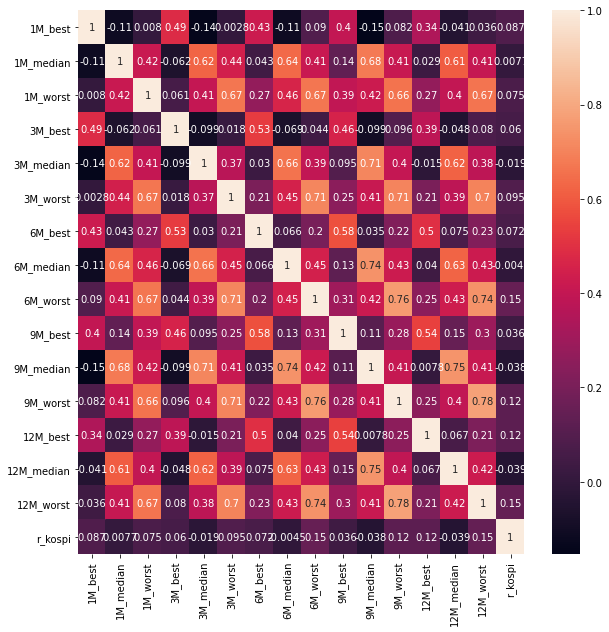

In [370]:
plt.figure(figsize=(10,10))
sns.heatmap(portfolio_kospi_rr.corr(), annot=True)

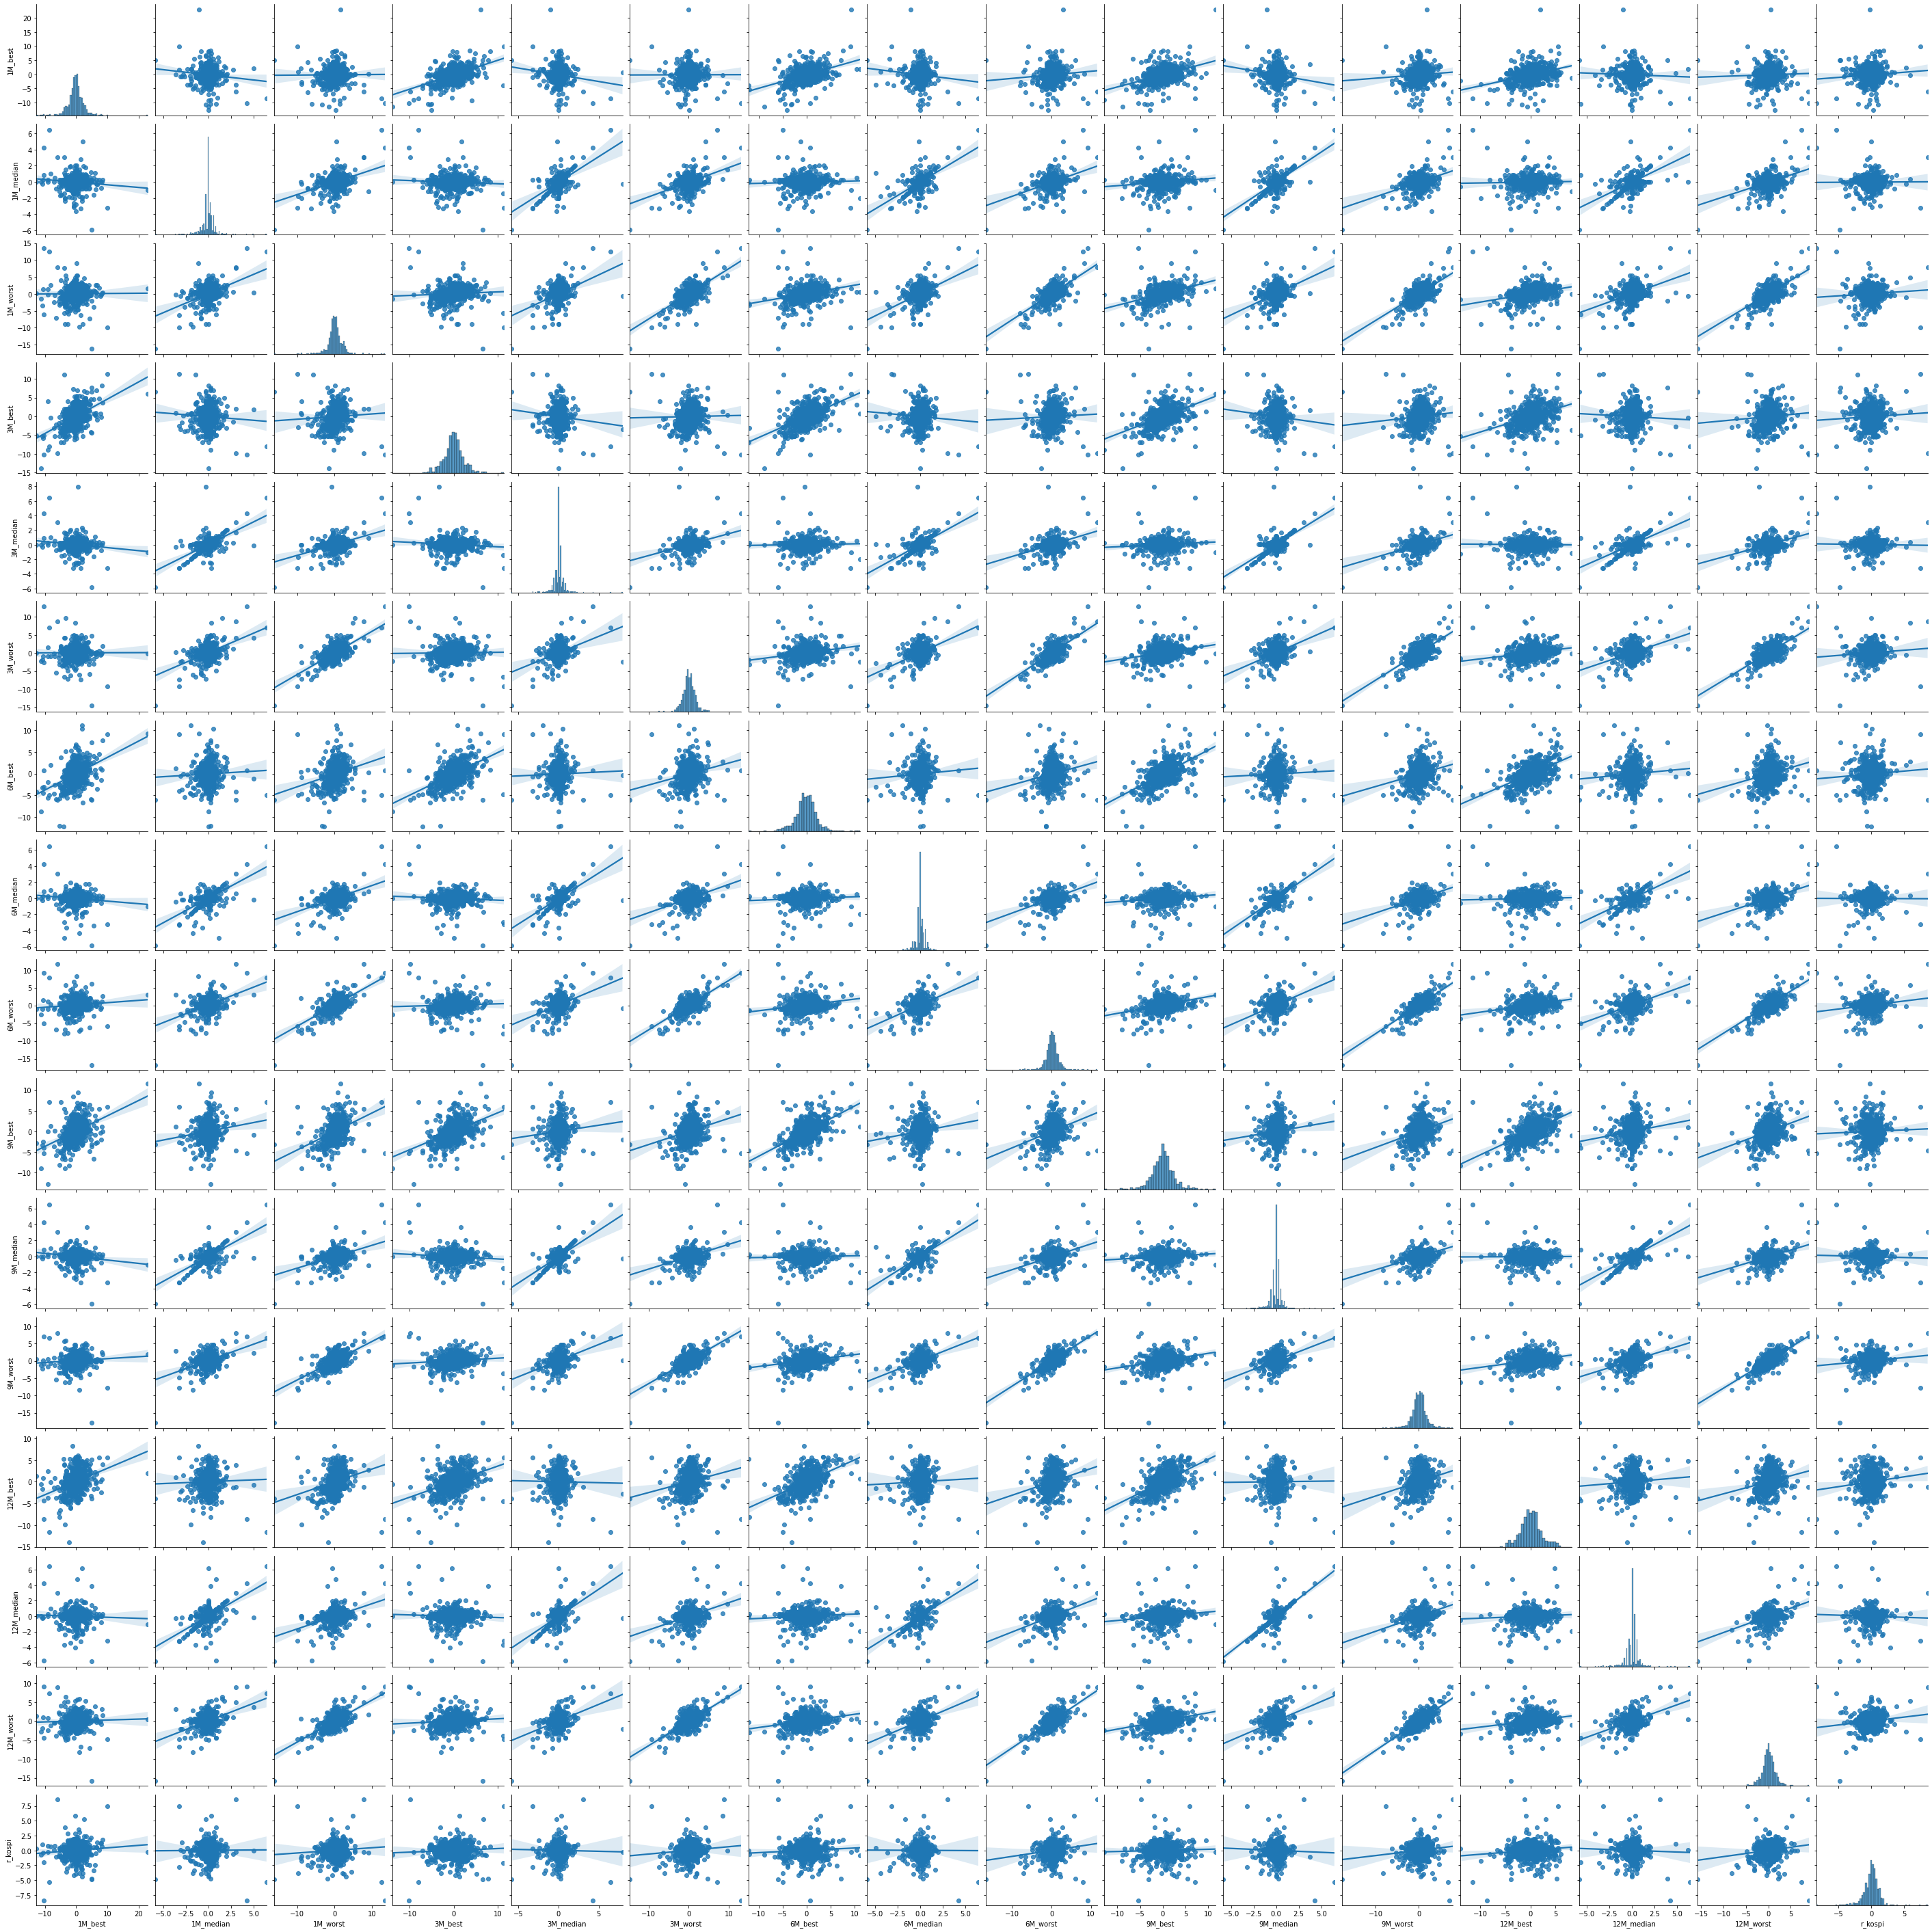

In [371]:
sns.pairplot(data=portfolio_kospi_rr, vars=portfolio_kospi_rr.columns, kind='reg')

### 문제 6.
- 15개 포트폴리오 수익률과 KOSPI 지수 수익률의 누적수익률 그래프를 그리시오.
    - (best vs. KOSPI, median vs. KOSPI, worst vs. KOSPI 로 구분하여 3개의 그래프로 그릴 것)


In [372]:
portfolio_kospi_rr.columns

Index(['1M_best', '1M_median', '1M_worst', '3M_best', '3M_median', '3M_worst',
       '6M_best', '6M_median', '6M_worst', '9M_best', '9M_median', '9M_worst',
       '12M_best', '12M_median', '12M_worst', 'r_kospi'],
      dtype='object')

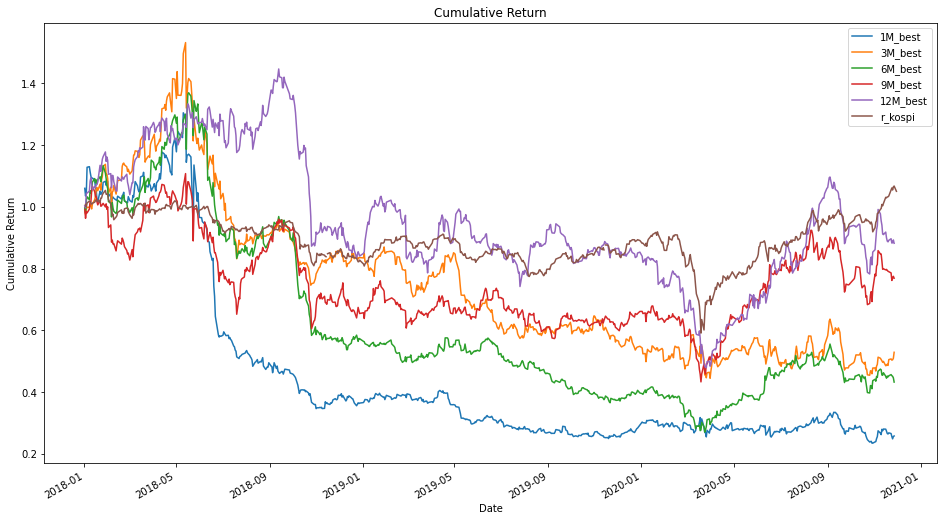

In [373]:
best_kospi_cumr = (1+portfolio_kospi_rr[['1M_best', '3M_best', '6M_best', '9M_best', '12M_best', 'r_kospi']]/100).cumprod()
best_kospi_cumr.plot(figsize=(16, 9))
plt.title('Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()

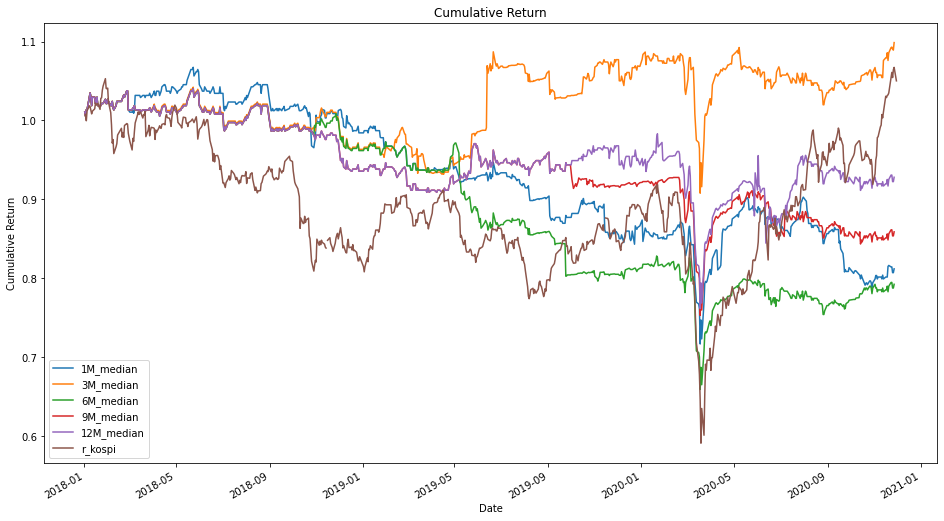

In [374]:
median_kospi_cumr = (1+portfolio_kospi_rr[['1M_median', '3M_median', '6M_median', '9M_median', '12M_median', 'r_kospi']]/100).cumprod()
median_kospi_cumr.plot(figsize=(16, 9))
plt.title('Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()

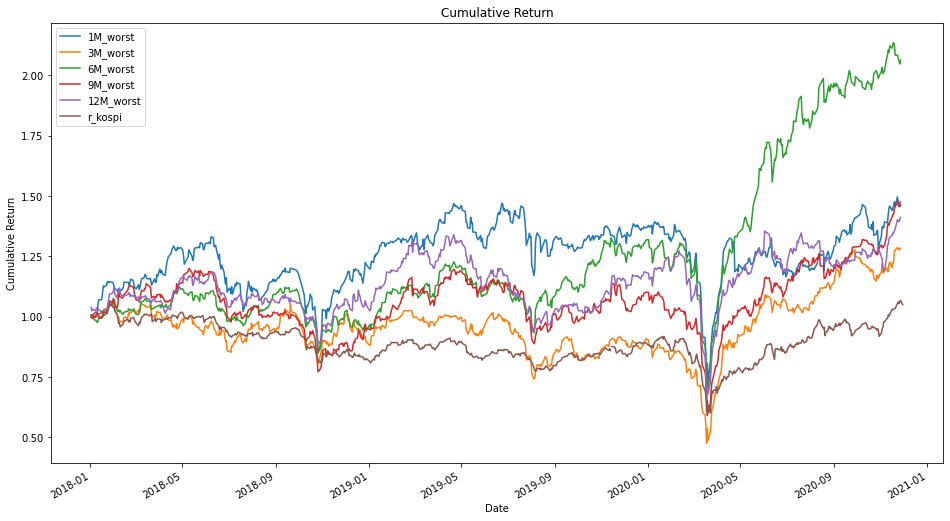

In [375]:
worst_kospi_cumr = (1+portfolio_kospi_rr[['1M_worst', '3M_worst', '6M_worst', '9M_worst', '12M_worst', 'r_kospi']]/100).cumprod()
worst_kospi_cumr.plot(figsize=(16, 9))
plt.title('Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()

### 문제 7.
- 위 결과를 바탕으로 최적의 투자전략을 제시하고, 그 근거를 설명하시오.

### Proposal

- 2018, 2019년 동안 주식시장의 질적 변화가 진행되었음
    - 1일보유 기준 수익률이 높은 best portfolio가 2019년 들어서면서 수익 급락세
    - 2019년 5월 3M Median 포트폴리오가 시장수익률을 상회
- Best performance는 6M_worst 포트폴리오
    - 6개월 모멘텀 수익률을 기준으로 하위권 종목이 2020년 들어 고공행진
    - 1-12개월 모멘텀 모두에서 수익률 하위권 종목이 코스피를 상회하는 이변 연출
    - 20년 이후 게임의 법칙이 달라졌다? 6개월 안팎 모멘텀으로 눈에 띄지 않는 바닥주 투자 추천

### 문제 8.
- 모멘텀 기간의 변화(23일 ∼ 253일)에 따른 portfolio(best, median, worst)의 누적수익률을 계산하고 그래프로 출력하시오.
    - (x축: 모멘텀 기간의 변화 (23일 ∼ 253일);
    - y축: 모멘텀 기간의 변화에 따른 포트폴리오별 최종시점의 누적수익률 추이)

In [382]:
portfolio_kospi_rr.columns

Index(['1M_best', '1M_median', '1M_worst', '3M_best', '3M_median', '3M_worst',
       '6M_best', '6M_median', '6M_worst', '9M_best', '9M_median', '9M_worst',
       '12M_best', '12M_median', '12M_worst', 'r_kospi'],
      dtype='object')

In [386]:
pf_1M = portfolio_kospi_rr[['1M_best', '1M_median', '1M_worst']].apply(np.mean, axis=1)
pf_3M = portfolio_kospi_rr[['3M_best', '3M_median', '3M_worst']].apply(np.mean, axis=1)
pf_6M = portfolio_kospi_rr[['6M_best', '6M_median', '6M_worst']].apply(np.mean, axis=1)
pf_9M = portfolio_kospi_rr[['9M_best', '9M_median', '9M_worst']].apply(np.mean, axis=1)
pf_12M = portfolio_kospi_rr[['12M_best', '12M_median', '12M_worst']].apply(np.mean, axis=1)

In [390]:
pf_1M_final = (1+pf_1M/100).cumprod().dropna()[-1]
pf_3M_final = (1+pf_3M/100).cumprod().dropna()[-1]
pf_6M_final = (1+pf_6M/100).cumprod().dropna()[-1]
pf_9M_final = (1+pf_9M/100).cumprod().dropna()[-1]
pf_12M_final = (1+pf_12M/100).cumprod().dropna()[-1]

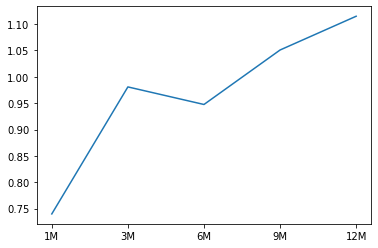

In [393]:
pf_M_finals = [pf_1M_final, pf_3M_final, pf_6M_final, pf_9M_final, pf_12M_final]
M_periods = ['1M', '3M', '6M', '9M', '12M']
plt.plot(M_periods, pf_M_finals)